<a href="https://colab.research.google.com/github/Sidhtang/30-day-ml-challenge-/blob/main/day_24_making_transformers_efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title  making models faster with quantization
# quantization takes a differnt approcah instead of reducing the number of computations ,it makes them much more efficient
# by representing the wieghts and activation with low precison data types like 8 bit integer



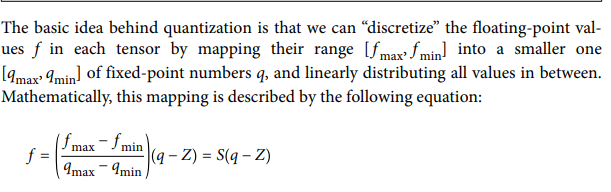

In [1]:
from PIL import Image

img = Image.open('/content/Screenshot 2024-08-30 113904.png')
display(img)
# one of the main reasons that rransfomres are quantized cause the weighrts
# and activations tend to take smaller places

In [3]:


#hide_output
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

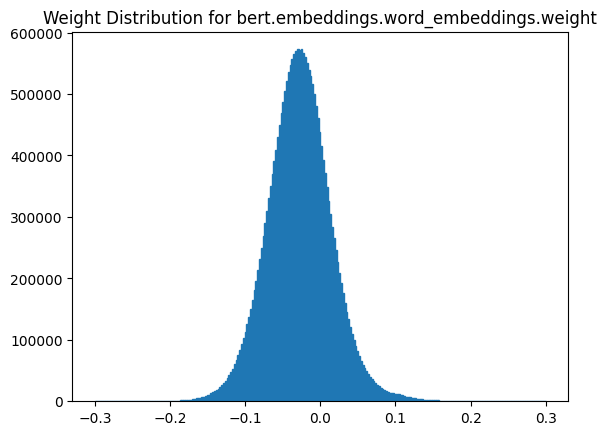

In [5]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()

# Iterate over the state dictionary to find weights
for key in state_dict.keys():
    if 'weight' in key:  # Check if the key corresponds to a weight parameter
        weights = state_dict[key]
        plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
        plt.title(f"Weight Distribution for {key}")
        plt.show()
        break  # Stop after plotting the first weight distribution

In [6]:
# quantixzing a tensor
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [7]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -1,  -9,  -4,  ...,  -3,  -5,  -1],
        [ -2,  -8,  -5,  ...,  -2,  -6,  -1],
        [ -3,  -9,  -5,  ...,  -2,  -6,   0],
        ...,
        [ -3,  -8,  -2,  ...,  -1,  -2,  -3],
        [ -6,  -8,   0,  ...,   2,  -2,  -1],
        [  0, -11,  -2,  ...,  -1,  -7,  11]], dtype=torch.int8)

In [ ]:
# @title Dyanimic quanitization
# for a full scale transformer we will define what layes to quantizer
# two types of quantization # static and dynamic
# dynamic
#When using dynamic quantization nothing is changed during training and the
#adaptations are only performed during inference. Like with all the quantization
#methods we will discuss, the weights of the model are converted to INT8 ahead
#of inference time.

In [ ]:
# @title Static quantization
#Instead of computing the quantization of the activations on the fly, we can avoid
 #the conversion to floating point by precomputing the quantization scheme. Static
 #quantization achieves this by observing the activation patterns on a representa‐
 # tive sample of the data ahead of inference time. The ideal quantization scheme is
 # calculated and then saved.


In [ ]:
# @title Quantization aware training
#The effect of quantization can be effectively simulated during training by “fake”
 #quantization of the FP32 values. Instead of using INT8 values during training,
 # the FP32 values are rounded to mimic the effect of quantization

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.quantization import quantize_dynamic
import torch
import torch.nn as nn

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Now AutoTokenizer should be accessible.
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [11]:
# benchmarking our quanized model



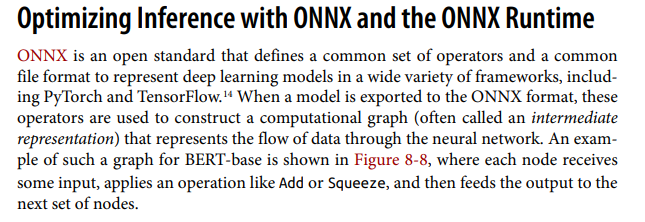

In [14]:
from PIL import Image
img = Image.open('/content/Screenshot 2024-08-30 120846.png') # Removed extra space before 'img'
display(img)

In [ ]:
#ONXX makes easy for us to switch between
# frameworks
# we will run our distleeld  odel on onnx

In [22]:
!pip install --upgrade onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.8 MB/s eta 0:00:00


In [31]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.4 MB/s eta 0:00:00
